<div style="text-align: center;">
    <h3>Applied Data Science Project</h3>
    <h2><b>Patient Preference Studies Classification System</b><h2>
    <h1><b>Design & Test Data Over-Samplers</b></h1>
    <h5>Francesco Giuseppe Gillio</h5>
    <h5>César Augusto Seminario Yrigoyen</h5>
</div>

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/it/4/47/Logo_PoliTo_dal_2021_blu.png" width="250">
</div>

https://github.com/adsp-polito/2024-P8-PPS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Drive* **Setup**

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Patient Preference Studies Binary Classifier
root = 'PPS-BC'

In [4]:
path = os.path.join('/content/drive/MyDrive', root)
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
paths = {
    'input-data': f'{root}/input-data',
    'bert-embeddings': f'{root}/bert-embeddings',
    'notebook-results': f'{root}/notebook-results',
}

In [6]:
for key, value in paths.items():
    path = os.path.join('/content/drive/MyDrive', value)
    if not os.path.exists(path):
        os.makedirs(path)

**Notebook Directory Structure**
```
/PPS-BC
└── /notebook-results
    └── /over-samplers
        └── ...
```

# *Data* **Over-Samplers**

**Requirements**

In [7]:
import os
import numpy as np

from typing import Dict, List, Tuple, Any

In [8]:
from imblearn.over_sampling import (
    BorderlineSMOTE,
    KMeansSMOTE,
    SVMSMOTE,
    ADASYN,
    SMOTEN,
    SMOTE
)

In [9]:
np.random.seed(42)

In [10]:
device = 'cpu'
device

'cpu'

In [11]:
output = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'over-samplers')
if not os.path.exists(output):
    os.makedirs(output)

In [12]:
with open(os.path.join(output, 'logs.txt'), 'w') as file:
    pass

**Data Over-Samplers**

In [13]:
samplers = [
    ('SMOTE', SMOTE(
        sampling_strategy="auto",
        random_state=42,
        k_neighbors=5
    )),
    ('Adaptive Synthetic (ADASYN)', ADASYN(
        sampling_strategy="auto",
        random_state=42,
        n_neighbors=5
    )),
    ('Borderline SMOTE', BorderlineSMOTE(
        sampling_strategy="auto",
        random_state=42,
        m_neighbors=10,
        k_neighbors=5
    )),
    ('KMeans SMOTE', KMeansSMOTE(
        sampling_strategy="auto",
        random_state=42,
        k_neighbors=5
    )),
    ('SVM-SMOTE', SVMSMOTE(
        sampling_strategy="auto",
        random_state=42,
        m_neighbors=10,
        k_neighbors=5
    )),
    ('SMOTEN', SMOTEN(
        sampling_strategy="auto",
        random_state=42,
        k_neighbors=5
    ))
]

* Model Check

In [14]:
def control(
    models: List[Tuple[str, any]],
    output: str
) -> List[Tuple[str, Any]]:
    """
    control function to validate samplers by fit_resample() method

    args:
        models (List[Tuple[str, any]]): a list of methods and samplers instances pairs
        output (str): path to output folder to store logs

    returns:
        List[Tuple[str, Any]]: a list of valid methods and samplers instances pairs
    """
    compatible = []
    for model, sampler in models:
        log = f'{model} model check...'
        with open(os.path.join(output, 'logs.txt'), 'a') as file:
            file.write(log + '\n')
        print(log)
        try:
            fit = callable(getattr(sampler, 'fit_resample', None))
            if fit:
                log = f'status: pass\n'
                compatible.append((model, sampler))
            else:
                log = f'status: out\n'
        except Exception as e:
            log = f'status: out\n'
        with open(os.path.join(output, 'logs.txt'), 'a') as file:
            file.write(log + '\n')
        print(log)
    return compatible

In [15]:
samplers = control(samplers, output)

SMOTE model check...
status: pass

Adaptive Synthetic (ADASYN) model check...
status: pass

Borderline SMOTE model check...
status: pass

KMeans SMOTE model check...
status: pass

SVM-SMOTE model check...
status: pass

SMOTEN model check...
status: pass



In [16]:
samplers.insert(0, ('Baseline', None))

# **Design & Test** *Data Over-Samplers* by *Linear Separation* via **Maximum-Margin Hyperplane**

## *Design & Test* **Requirements**

**Requirements**

In [17]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple, Any

In [18]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss
)

In [19]:
np.random.seed(42)

In [20]:
device = 'cpu'
device

'cpu'

In [21]:
input = f"/content/drive/MyDrive/{paths['input-data']}"

In [22]:
branch = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'over-samplers')

**Evaluation Metrics**

In [23]:
def compute(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray
) -> Dict[str, float]:
    """
    compute classification metrics for predictions

    args:
        y_true (np.ndarray): ground truth labels for the test set
        y_pred (np.ndarray): predictions for the test set
        y_prob (np.ndarray): probabilities for the positive class

    returns:
        Dict[str, float]: a dictionary with classification metrics
    """
    metrics = {
        'F2-PPS': fbeta_score(
            y_true, y_pred, beta=2, pos_label=1
        ),  # F2-Score (Class 1)
        'F1-PPS': f1_score(
            y_true, y_pred, pos_label=1
        ),  # F1-Score (Class 1)

        'TPR': recall_score(
            y_true, y_pred, pos_label=1
        ),  # True Positive Rate (TPR)
        'FNR': 1 - recall_score(
            y_true, y_pred, pos_label=1
        ),  # False Negative Rate (FNR)
        'PPV': precision_score(
            y_true, y_pred, pos_label=1
        ),  # Positive Predictive Value (PPV)
        'FDR': 1 - precision_score(
            y_true, y_pred, pos_label=1
        ),  # False Discovery Rate (FDR)

        'AUC-PR': average_precision_score(
            y_true, y_prob
        ),  # Area Under Precision-Recall Curve (AUC-PR)
        'BA': balanced_accuracy_score(
            y_true, y_pred
        ),  # Balanced Accuracy (BA)
        'AUC-ROC': roc_auc_score(
            y_true, y_prob
        ),  # Area Under ROC Curve (AUC-ROC)

        'G-Mean': np.sqrt(
            recall_score(
                y_true, y_pred, pos_label=1
            ) *
            recall_score(
                y_true, y_pred, pos_label=0
            )
        ),  # Geometric Mean (G-Mean)
        'MCC': matthews_corrcoef(
            y_true, y_pred
        ),  # Matthews Correlation Coefficient (MCC)

        'Log-Loss': log_loss(
            y_true, y_prob
        ),  # Log-Loss
        'BS': brier_score_loss(
            y_true, y_prob
        ),  # Brier Score

        'TNR': recall_score(
            y_true, y_pred, pos_label=0
        ),  # True Negative Rate (TNR)
        'FPR': 1 - recall_score(
            y_true, y_pred, pos_label=0
        ),  # False Positive Rate (FPR)
        'NPV': precision_score(
            y_true, y_pred, pos_label=0
        ),  # Negative Predictive Value (NPV)
        'FOR': 1 - precision_score(
            y_true, y_pred, pos_label=0
        ),  # False Omission Rate (FOR)

        'Accuracy': accuracy_score(
            y_true, y_pred
        ),  # Accuracy
        'Weighted F1-Score': f1_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted F1-Score
        'Weighted Precision': precision_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted Precision
        'Weighted Recall': recall_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted Recall
        'Macro F1-Score': f1_score(
            y_true, y_pred, average='macro'
        ),  # Macro F1-Score
        'Macro Precision': precision_score(
            y_true, y_pred, average='macro'
        ),  # Macro Precision
        'Macro Recall': recall_score(
            y_true, y_pred, average='macro'
        )   # Macro Recall
    }
    return metrics

*Evaluation Metrics Sorting Criteria*

In [24]:
order = [
    'F2-PPS', # F2-Score (Class 1 - Patient Preference Studies)
    'F1-PPS', # F1-Score (Class 1 - Patient Preference Studies)
    'TPR',    # True Positive Rate
    'PPV',    # Positive Predictive Value
    'AUC-PR', # Area Under Precision-Recall Curve
    'BA',     # Balanced Accuracy
    'AUC-ROC' # Area Under ROC Curve
]

**Binary Classification**

In [25]:
def evaluate(
    dir: str,
    loc: str,
    case: str,
    input: str,
    output: str,
    samplers: List[Tuple[str, any]],
    order = List[str]
) -> pd.DataFrame:
    """
    evaluate data over-samplers by Linear Separation via Maximum-Margin Hyperplane

    args:
        dir (str): path to the directory with bert-base model
        loc (str): path to file with title-abstract link (.pkl file)
        case (str): cross-validation case identifier (e.g. 'k-fold-2' or 'k-fold-3')
        input (str): path to the input folder with data and splits
        output (str): path to output folder to store logs
        samplers (List[Tuple[str, any]]): a list of methods and samplers instances pairs
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with evaluation results
    """

    def add(
        by: str,
        to: str
    ) -> pd.DataFrame:
        """
        add an embeddings column to the input split file

        args:
            by (str): path to the .pkl file with embeddings
            to (str): path to the .csv split file
        """
        dataset = pd.read_pickle(by)
        frame = pd.read_csv(to)
        embeddings = [
            column for column in dataset.columns
            if column not in ['title', 'abstract', 'label']
        ]
        data = frame.merge(
            dataset[['title', 'abstract', 'label'] + embeddings],
            on=['title', 'abstract', 'label'],
            how='left'
        )
        return data

    def collect(
        dir: str
    ) -> List[Tuple[str, str]]:
        """
        collect train and test file pairs from the directory

        args:
            dir (str): path to the directory with train/test files

        returns:
            List[Tuple[str, str]]: list of (train file, test file) tuples
        """
        files = {'train': [], 'test': []}
        for idx, _, walk in os.walk(dir):
            for file in walk:
                if file.endswith('.csv'):
                    if 'train' in file:
                        files['train'].append(
                            os.path.join(idx, file)
                        )
                    elif 'test' in file:
                        files['test'].append(
                            os.path.join(idx, file)
                        )
        files['train'].sort()
        files['test'].sort()
        return list(zip(files['train'], files['test']))

    log = f'\n{case}\n'
    with open(os.path.join(output, 'logs.txt'), 'a') as file:
        file.write(log + '\n')
    steps = len(samplers) * len(
        collect(
            os.path.join(input, 'cv-splits', case)
        )
    )
    progress = 0
    results = list()
    print(f"processing {case}...")
    for method, sampler in samplers:
        log = f'-' * 50 + '\n' + f'Data Over-Sampler Model: {method}\n' + f'-' * 50 + '\n'
        with open(os.path.join(output, 'logs.txt'), 'a') as file:
            file.write(log + '\n')
        averages = {}
        route = os.path.join(input, 'cv-splits', case)
        for files in collect(route):
            progress += 1
            percentage = (progress / steps) * 100
            sys.stdout.write(f"\revaluating data over-sampler models... {percentage:.2f}%")
            sys.stdout.flush()
            log = f'classifier execution on:\n- train file: {os.path.basename(files[0])}\n- test file: {os.path.basename(files[1])}'
            with open(os.path.join(output, 'logs.txt'), 'a') as file:
                file.write(log + '\n')
            embeddings = os.path.join(dir, loc)
            data_train = add(
                by=embeddings,
                to=files[0]
            )
            data_test = add(
                by=embeddings,
                to=files[1]
            )
            y_train = data_train['label']
            y_test = np.array(data_test['label'].tolist())
            # skip non-embedding columns
            column = [
                column for column in data_train.columns
                if column not in ['label', 'title', 'abstract']
            ][0]
            if not isinstance(data_train[column].values[0], np.ndarray):
                # debug
                print(f'\nWARNING: {column} not of type np.ndarray')
                continue
            x_train = np.array(data_train[column].tolist())
            x_test = np.array(data_test[column].tolist())
            try:
                if sampler is not None:
                    x_train, y_train = sampler.fit_resample(x_train, y_train)
                svm = SVC(
                    kernel='linear',
                    probability=True,
                    class_weight='balanced',
                    random_state=42,
                    max_iter=1000
                    )
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('svm', svm)
                ])
                # train
                pipeline.fit(x_train, y_train)
                # test
                y_pred = pipeline.predict(x_test)
                y_prob = pipeline.predict_proba(x_test)
                metrics = compute(
                    y_true=y_test,
                    y_pred=y_pred,
                    y_prob=y_prob[:, 1]
                )
                for metric in ['F2-PPS', 'F1-PPS', 'TPR', 'PPV']:
                    log = f"{metric}: {metrics[metric]}"
                    with open(os.path.join(output, 'logs.txt'), 'a') as file:
                        file.write(log + '\n')
            except Exception as e:
                # debug
                # print(f'\nERROR for {column}:\n{e}')
                continue
            if method not in averages:
                averages[method] = {
                    key: [] for key in metrics
                }
            for key, value in metrics.items():
                averages[method][key].append(value)
        for approach, scores in averages.items():
            mean = {
                key: np.mean(values)
                for key, values in scores.items()
            }
            results.append({
                'Data Over-Sampler Model': approach,
                **mean
            })
            for idx, metric in enumerate(['F2-PPS', 'F1-PPS', 'TPR', 'PPV']):
                log = ('\n' if idx == 0 else '') + metric + ': ' + str(mean[metric])
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
    print()
    data = pd.DataFrame(results)
    data = data.sort_values(
        by=order,
        ascending=[False] * len(order)
    )
    return data

*Statistical* **Data Analysis**

In [26]:
def combine(
    dir: str,
    main: List[str],
    order: List[str]
) -> pd.DataFrame:
    """
    combine multiple .csv files into a single DataFrame

    args:
        dir (str): path to the folder with .csv files
        main (List[str]): main group-by columns
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with scores
    """
    files = glob.glob(os.path.join(dir, "*.csv"))
    data = list()
    for file in files:
        frame = pd.read_csv(file)
        data.append(frame)
    concat = pd.concat(data)
    data = (
        concat.groupby(main)
        .agg(
            ['mean', 'std']
        )
        .reset_index()
    )
    data.columns = [
        '-'.join(column).strip('-') for column in data.columns
        if column not in main
    ]
    for column in data.columns:
        if column.endswith('-mean'):
            base = column.rsplit('-', 1)[0]
            deviation = f'{base}-std'
            if deviation in data.columns:
                # compute confidence interval
                N = len(concat.groupby(main))
                sem = data[deviation] / np.sqrt(N)
                deg = N - 1
                # 99% confidence level
                critical = stats.t.ppf(0.995, deg)
                lower = data[column] - critical * sem
                upper = data[column] + critical * sem
                data[f'{base}-ci'] = (
                    data[column].round(3).astype(str) + " ± " +
                    ((upper - lower) / 2).round(3).astype(str)
                )
    data = data.sort_values(
        by=[f"{metric}-mean" for metric in order],
        ascending=[False] * len(order)
    )
    columns = [
        column for column in data.columns
        if column.endswith('-ci')
    ]
    data = data[main + columns]
    data.columns = [
        column.replace('-ci', '') for column in data.columns
    ]
    return data

In [27]:
def get(
    data: pd.DataFrame,
    case: str,
    order: List[str]
) -> pd.DataFrame:
    """
    get a dataframe by group-by on input column

    args:
        data (pd.DataFrame): DataFrame with evaluation results
        case (str): group-by column to plot (e.g., 'BERT-Base Model')
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with scores
    """
    data = data[[case] + order].copy()
    for metric in order:
        data[metric] = data[metric].str.extract(r'(\d+\.\d+)').astype(float)
    res = (
        data.groupby(case)
        .agg(
            ['mean', 'std']
        )
        .reset_index()
    )
    res.columns = [
        '-'.join(column).strip('-') for column in res.columns
        if column not in [case]
    ]
    for column in res.columns:
        if column.endswith('-mean'):
            base = column.rsplit('-', 1)[0]
            deviation = f'{base}-std'
            if deviation in res.columns:
                # compute confidence interval
                N = len(data.groupby([case]))
                sem = res[deviation] / np.sqrt(N)
                deg = N - 1
                # 99% confidence level
                critical = stats.t.ppf(0.995, deg)
                lower = res[column] - critical * sem
                upper = res[column] + critical * sem
                res[f'{base}-ci'] = (
                    res[column].round(3).astype(str) + " ± " +
                    ((upper - lower) / 2).round(3).astype(str)
                )
    res = res.sort_values(
        by=[f"{metric}-mean" for metric in order],
        ascending=[False] * len(order)
    )
    columns = [
        column for column in res.columns
        if column.endswith('-ci')
    ]
    res = res[[case] + columns]
    res.columns = [
        column.replace('-ci', '') for column in res.columns
    ]
    return res

In [28]:
def plot(
    data: pd.DataFrame,
    column: str,
    output: str,
    order: List[str]
) -> None:
    """
    plot performance metrics with confidence intervals

    args:
        data (pd.DataFrame): DataFrame with evaluation results
        column (str): group-by column to plot (e.g., 'BERT-Base Model')
        output (str): path to output folder to store plot
        order (List[str]): evaluation metrics sorting criteria
    """
    chart = list()
    for metric in order:
        if metric in data.columns:
            for _, row in data.iterrows():
                ci = row[metric].split(' ± ')
                mean = float(ci[0])
                error = float(ci[1])
                chart.append({
                    column: row[column],
                    'Metric': metric,
                    'Mean': mean,
                    'Error': error
                })
    chart = pd.DataFrame(chart)
    chart[column] = chart[column].astype(str)
    plt.figure(figsize=(16, 9))
    position = -0.75
    ax = sns.barplot(
        chart,
        x=column,
        y='Mean',
        hue='Metric',
        ci=None,
        palette='crest'
    )
    for bar, (_, row) in zip(ax.patches, chart.iterrows()):
        center = bar.get_x() + bar.get_width() / 2
        lower = row['Mean'] - row['Error']
        upper = row['Mean'] + row['Error']
        plt.errorbar(
            x=center,
            y=row['Mean'],
            yerr=row['Error'],
            fmt='none',
            color='black',
            linestyle='-',
            linewidth=0.5
        )
    for idx, metric in enumerate(chart['Metric'].unique()):
        columns = chart[chart['Metric'] == metric]
        row = columns.loc[columns['Mean'].idxmax()]
        value = row['Mean']
        center = (
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_x() +
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_width() / 2
        )
        if metric == 'F2-PPS':
            ax.plot(
                [center, position],
                [value, value],
                color='black',
                linestyle='--',
                linewidth=0.5
            )
            ax.text(
                x=position,
                y=value,
                s=f'{value:.3f}',
                ha='right',
                va='center',
                fontsize=10
            )
    plt.title(
        f'{column} Performance Distributions',
        fontsize=15
    )
    plt.xlabel(
        column,
        fontsize=10
    )
    plt.ylabel(
        'Metric Value',
        fontsize=10
    )
    plt.legend(
        title=f'Metric',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode='anchor'
    )
    plt.ylim(
        bottom=min(
            chart['Mean'] - chart['Error']
        )
    )
    plt.tight_layout()
    plt.savefig(
        f'{output}/{column.lower().replace(" ", "-")}-performance-plot.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

*What to* **Move Forward**

In [29]:
def select(
    dir: str,
    title: str,
    column: str,
    output: str,
    main: List[str],
    order: List[str],
    model: Dict[str, str] = None
) -> pd.DataFrame:
    """
    what to move forward

    args:
        dir (str): path to the folder with .csv file
        title (str): plot title
        column (str): group-by column to plot (e.g., 'BERT-Base Model')
        output (str): path to output folder to store plot
        main (List[str]): main group-by columns
        order (List[str]): evaluation metrics sorting criteria
        model (Dict[str, str], optional): dictionary with {'BERT-Base Model': 'bert-base model'} to filter

    returns:
        pd.DataFrame: DataFrame with scores
    """
    data = pd.read_csv(dir)
    data = data[main + order]
    if model:
        key, value = next(iter(model.items()))
        data = data[data[key] == value]
    def lower(value):
        base, error = map(float, value.split(' ± '))
        return base - error
    for metric in order:
        data[metric] = data[metric].apply(lower)
    data = data.sort_values(
        by=order,
        ascending=[False] * len(order)
    )
    data.to_csv(os.path.join(output, f'{title.lower().replace(" ", "-")}-ranks.csv'), encoding='utf-8', index=False)
    chart = []
    for metric in order:
        if metric in data.columns:
            for _, row in data.iterrows():
                mean = float(row[metric])
                chart.append({
                    column: row[column],
                    'Metric': metric,
                    'Mean': mean
                })
    chart = pd.DataFrame(chart)
    chart[column] = chart[column].astype(str)
    plt.figure(figsize=(16, 9))
    position = -0.75
    ax = sns.barplot(
        chart,
        x=column,
        y='Mean',
        hue='Metric',
        palette='crest'
    )
    for idx, metric in enumerate(chart['Metric'].unique()):
        columns = chart[chart['Metric'] == metric]
        row = columns.loc[columns['Mean'].idxmax()]
        value = row['Mean']
        center = (
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_x() +
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_width() / 2
        )
        if metric == 'F2-PPS':
            ax.plot(
                [center, position],
                [value, value],
                color='black',
                linestyle='--',
                linewidth=0.5
            )
            ax.text(
                x=position,
                y=value,
                s=f'{value:.3f}',
                ha='right',
                va='center',
                fontsize=10
            )
    plt.title(
        f'{title} Performance Distributions',
        fontsize=15
    )
    plt.xlabel(
        column,
        fontsize=10
    )
    plt.ylabel(
        'Metric Value',
        fontsize=10
    )
    plt.legend(
        title=f'Metric',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode='anchor'
    )
    plt.ylim(
        bottom=min(
            chart['Mean']
        )
    )
    plt.tight_layout()
    plt.savefig(
        f'{output}/{title.lower().replace(" ", "-")}-performance-plot.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()
    return data

## **Design & Test** *Data Over-Samplers* for **BiomedNLP-BiomedBERT-base-uncased-abstract**

*BiomedNLP-BiomedBERT-base-uncased-abstract*

In [30]:
output = os.path.join(branch, 'BiomedNLP-BiomedBERT-base-uncased-abstract')
if not os.path.exists(output):
    os.makedirs(output)

In [31]:
with open(os.path.join(output, 'logs.txt'), 'w') as file:
    pass

**BERT-Base Model:** *BiomedNLP-BiomedBERT-base-uncased-abstract*

In [32]:
model = os.path.join(f"/content/drive/MyDrive/{paths['bert-embeddings']}", 'BiomedNLP-BiomedBERT-base-uncased-abstract')

**T&A Link:** *vector-weighted-average-2080-hidden-states*

In [33]:
link = 'vector-weighted-average-2080-hidden-states.pkl'

*Fibonacci Sequence:* **[2, 3, 5, 8, 13, 21]**

Splits: **[2 + 3 + 21]** & **[5 + 8 + 13]**

*Split into 2 blocks of 26 iterations for* **M** *configurations, with* **M = 7** *data over-samplers*

*Computational effort per split:* **Mx26 = 7x26=182** *iterations on* **1.215** *data points each*

In [34]:
for seed in [2, 3, 21]:
    results = evaluate(
        dir = model,
        loc = link,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        samplers = samplers,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-2...
evaluating data over-sampler models... 100.00%
processing k-fold-3...
evaluating data over-sampler models... 100.00%
processing k-fold-21...
evaluating data over-sampler models... 100.00%


In [35]:
for seed in [5, 8, 13]:
    results = evaluate(
        dir = model,
        loc = link,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        samplers = samplers,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-5...
evaluating data over-sampler models... 100.00%
processing k-fold-8...
evaluating data over-sampler models... 100.00%
processing k-fold-13...
evaluating data over-sampler models... 100.00%


**Global** *Statistical Data Analysis*

In [36]:
results = combine(
    dir = output,
    main = ['Data Over-Sampler Model'],
    order = order
)
results.head()

,Data Over-Sampler Model,F2-PPS,F1-PPS,TPR,FNR,PPV,FDR,AUC-PR,BA,AUC-ROC,...,FPR,NPV,FOR,Accuracy,Weighted F1-Score,Weighted Precision,Weighted Recall,Macro F1-Score,Macro Precision,Macro Recall
5,SMOTEN,0.882 ± 0.007,0.888 ± 0.005,0.878 ± 0.01,0.122 ± 0.01,0.903 ± 0.016,0.097 ± 0.016,0.955 ± 0.007,0.928 ± 0.004,0.986 ± 0.002,...,0.023 ± 0.004,0.972 ± 0.002,0.028 ± 0.002,0.959 ± 0.002,0.958 ± 0.002,0.959 ± 0.003,0.959 ± 0.002,0.931 ± 0.003,0.938 ± 0.008,0.928 ± 0.004
4,SMOTE,0.881 ± 0.006,0.889 ± 0.009,0.877 ± 0.007,0.123 ± 0.007,0.907 ± 0.018,0.093 ± 0.018,0.953 ± 0.009,0.927 ± 0.004,0.986 ± 0.002,...,0.022 ± 0.004,0.972 ± 0.002,0.028 ± 0.002,0.959 ± 0.004,0.959 ± 0.004,0.96 ± 0.004,0.959 ± 0.004,0.932 ± 0.005,0.939 ± 0.01,0.927 ± 0.004
2,Borderline SMOTE,0.881 ± 0.007,0.888 ± 0.01,0.877 ± 0.005,0.123 ± 0.005,0.903 ± 0.02,0.097 ± 0.02,0.953 ± 0.008,0.927 ± 0.004,0.986 ± 0.002,...,0.023 ± 0.004,0.972 ± 0.001,0.028 ± 0.001,0.958 ± 0.004,0.958 ± 0.004,0.959 ± 0.005,0.958 ± 0.004,0.931 ± 0.006,0.938 ± 0.01,0.927 ± 0.004
1,Baseline,0.881 ± 0.006,0.888 ± 0.01,0.877 ± 0.004,0.123 ± 0.004,0.905 ± 0.022,0.095 ± 0.022,0.953 ± 0.009,0.927 ± 0.004,0.986 ± 0.002,...,0.022 ± 0.005,0.972 ± 0.001,0.028 ± 0.001,0.959 ± 0.005,0.958 ± 0.004,0.959 ± 0.005,0.959 ± 0.005,0.932 ± 0.007,0.939 ± 0.012,0.927 ± 0.004
0,Adaptive Synthetic (ADASYN),0.88 ± 0.007,0.888 ± 0.009,0.876 ± 0.007,0.124 ± 0.007,0.904 ± 0.018,0.096 ± 0.018,0.953 ± 0.009,0.927 ± 0.004,0.986 ± 0.002,...,0.022 ± 0.004,0.972 ± 0.002,0.028 ± 0.002,0.958 ± 0.004,0.958 ± 0.004,0.959 ± 0.004,0.958 ± 0.004,0.931 ± 0.006,0.938 ± 0.009,0.927 ± 0.004


In [37]:
results.to_csv(os.path.join(output, f'ranks.csv'), encoding='utf-8', index=False)

**Local** *Statistical Data Analysis* - **by Data Over-Sampler Model**

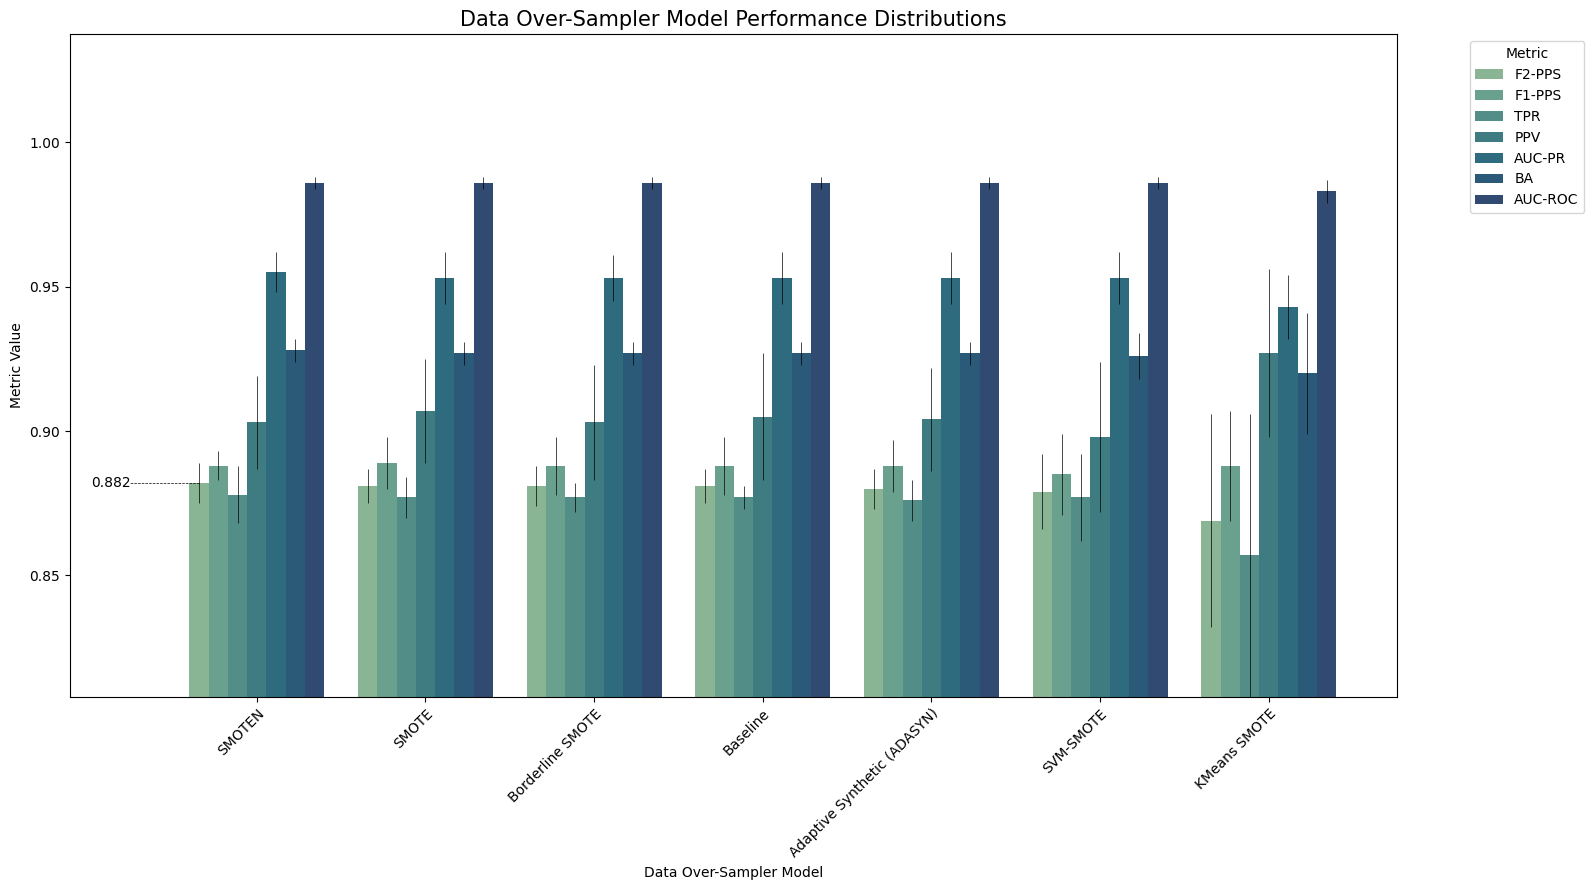

In [38]:
frame = results[['Data Over-Sampler Model'] + order].copy()

plot(frame, 'Data Over-Sampler Model', output, order)

* Select the **Data Over-Sampler Model** with the *highest performance at the lower bound of the confidence interval*

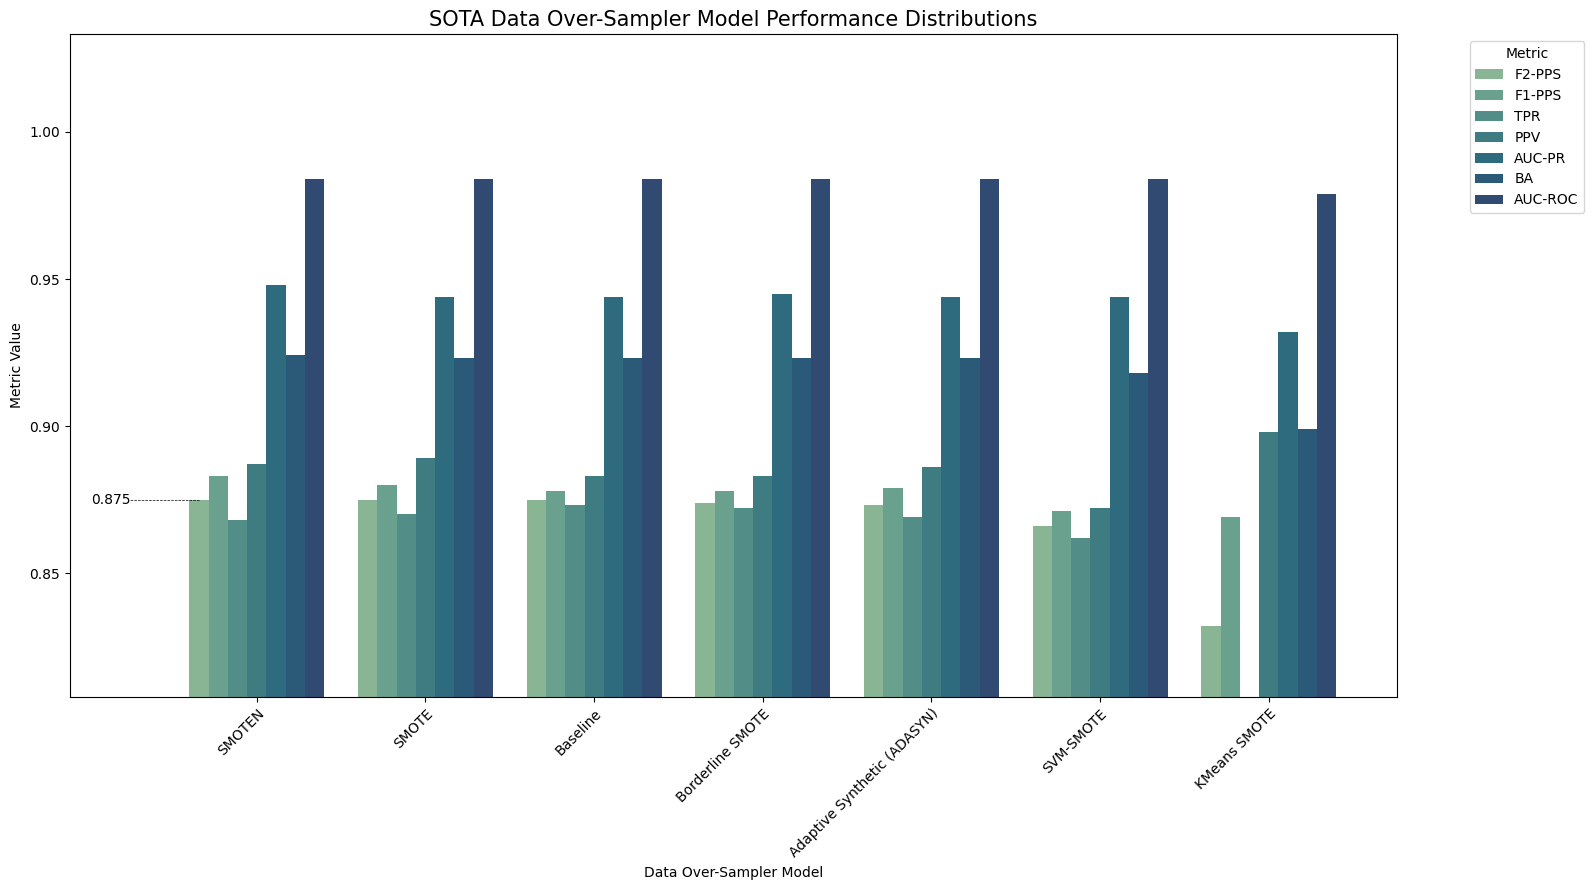

In [39]:
base = select(
    dir = os.path.join(output, f'ranks.csv'),
    title = "SOTA Data Over-Sampler Model",
    column = 'Data Over-Sampler Model',
    output = output,
    main = ['Data Over-Sampler Model'],
    order = order,
    model = None
)

## **Design & Test** *Data Over-Samplers* for **pubmedbert-base-embeddings**

*pubmedbert-base-embeddings*

In [40]:
output = os.path.join(branch, 'pubmedbert-base-embeddings')
if not os.path.exists(output):
    os.makedirs(output)

In [41]:
with open(os.path.join(output, 'logs.txt'), 'w') as file:
    pass

**BERT-Base Model:** *pubmedbert-base-embeddings*

In [42]:
model = os.path.join(f"/content/drive/MyDrive/{paths['bert-embeddings']}", 'pubmedbert-base-embeddings')

**T&A Link:** *vector-concatenation-classification-token*

In [43]:
link = 'vector-concatenation-classification-token.pkl'

*Fibonacci Sequence:* **[2, 3, 5, 8, 13, 21]**

Splits: **[2 + 3 + 21]** & **[5 + 8 + 13]**

*Split into 2 blocks of 26 iterations for* **M** *configurations, with* **M = 7** *data over-samplers*

*Computational effort per split:* **Mx26 = 7x26=182** *iterations on* **1.215** *data points each*

In [44]:
for seed in [2, 3, 21]:
    results = evaluate(
        dir = model,
        loc = link,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        samplers = samplers,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-2...
evaluating data over-sampler models... 100.00%
processing k-fold-3...
evaluating data over-sampler models... 100.00%
processing k-fold-21...
evaluating data over-sampler models... 100.00%


In [45]:
for seed in [5, 8, 13]:
    results = evaluate(
        dir = model,
        loc = link,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        samplers = samplers,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-5...
evaluating data over-sampler models... 100.00%
processing k-fold-8...
evaluating data over-sampler models... 100.00%
processing k-fold-13...
evaluating data over-sampler models... 100.00%


**Global** *Statistical Data Analysis*

In [46]:
results = combine(
    dir = output,
    main = ['Data Over-Sampler Model'],
    order = order
)
results.head()

,Data Over-Sampler Model,F2-PPS,F1-PPS,TPR,FNR,PPV,FDR,AUC-PR,BA,AUC-ROC,...,FPR,NPV,FOR,Accuracy,Weighted F1-Score,Weighted Precision,Weighted Recall,Macro F1-Score,Macro Precision,Macro Recall
2,Borderline SMOTE,0.886 ± 0.007,0.894 ± 0.005,0.882 ± 0.011,0.118 ± 0.011,0.913 ± 0.023,0.087 ± 0.023,0.953 ± 0.007,0.931 ± 0.004,0.983 ± 0.003,...,0.021 ± 0.005,0.973 ± 0.002,0.027 ± 0.002,0.961 ± 0.002,0.961 ± 0.002,0.962 ± 0.003,0.961 ± 0.002,0.935 ± 0.003,0.943 ± 0.01,0.931 ± 0.004
1,Baseline,0.886 ± 0.008,0.895 ± 0.006,0.881 ± 0.011,0.119 ± 0.011,0.914 ± 0.02,0.086 ± 0.02,0.952 ± 0.008,0.93 ± 0.004,0.983 ± 0.003,...,0.02 ± 0.004,0.973 ± 0.002,0.027 ± 0.002,0.961 ± 0.002,0.961 ± 0.002,0.962 ± 0.003,0.961 ± 0.002,0.935 ± 0.004,0.943 ± 0.009,0.93 ± 0.004
5,SMOTEN,0.886 ± 0.013,0.893 ± 0.008,0.882 ± 0.016,0.118 ± 0.016,0.909 ± 0.02,0.091 ± 0.02,0.953 ± 0.009,0.93 ± 0.007,0.983 ± 0.004,...,0.022 ± 0.004,0.973 ± 0.003,0.027 ± 0.003,0.96 ± 0.003,0.96 ± 0.003,0.961 ± 0.003,0.96 ± 0.003,0.934 ± 0.005,0.941 ± 0.009,0.93 ± 0.007
4,SMOTE,0.886 ± 0.007,0.895 ± 0.004,0.88 ± 0.011,0.12 ± 0.011,0.915 ± 0.019,0.085 ± 0.019,0.952 ± 0.009,0.93 ± 0.004,0.983 ± 0.003,...,0.02 ± 0.004,0.973 ± 0.002,0.027 ± 0.002,0.961 ± 0.002,0.961 ± 0.002,0.962 ± 0.002,0.961 ± 0.002,0.935 ± 0.003,0.944 ± 0.009,0.93 ± 0.004
0,Adaptive Synthetic (ADASYN),0.884 ± 0.006,0.893 ± 0.007,0.879 ± 0.009,0.121 ± 0.009,0.914 ± 0.024,0.086 ± 0.024,0.953 ± 0.008,0.929 ± 0.003,0.983 ± 0.003,...,0.02 ± 0.005,0.972 ± 0.002,0.028 ± 0.002,0.961 ± 0.003,0.96 ± 0.003,0.961 ± 0.004,0.961 ± 0.003,0.935 ± 0.004,0.943 ± 0.012,0.929 ± 0.003


In [47]:
results.to_csv(os.path.join(output, f'ranks.csv'), encoding='utf-8', index=False)

**Local** *Statistical Data Analysis* - **by Data Over-Sampler Model**

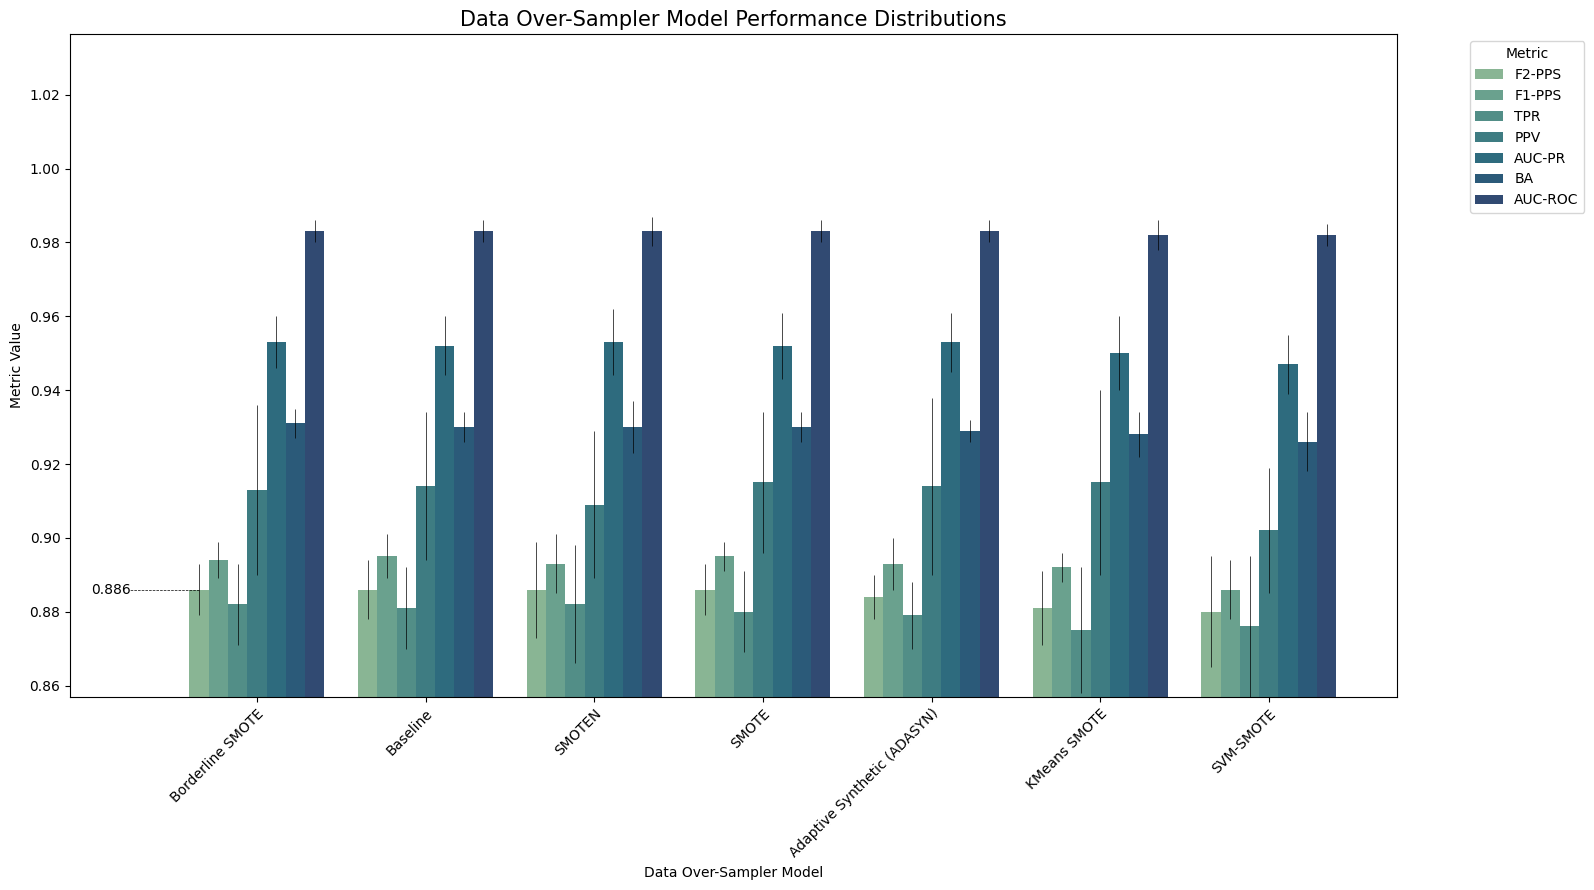

In [48]:
frame = results[['Data Over-Sampler Model'] + order].copy()

plot(frame, 'Data Over-Sampler Model', output, order)

* Select the **Data Over-Sampler Model** with the *highest performance at the lower bound of the confidence interval*

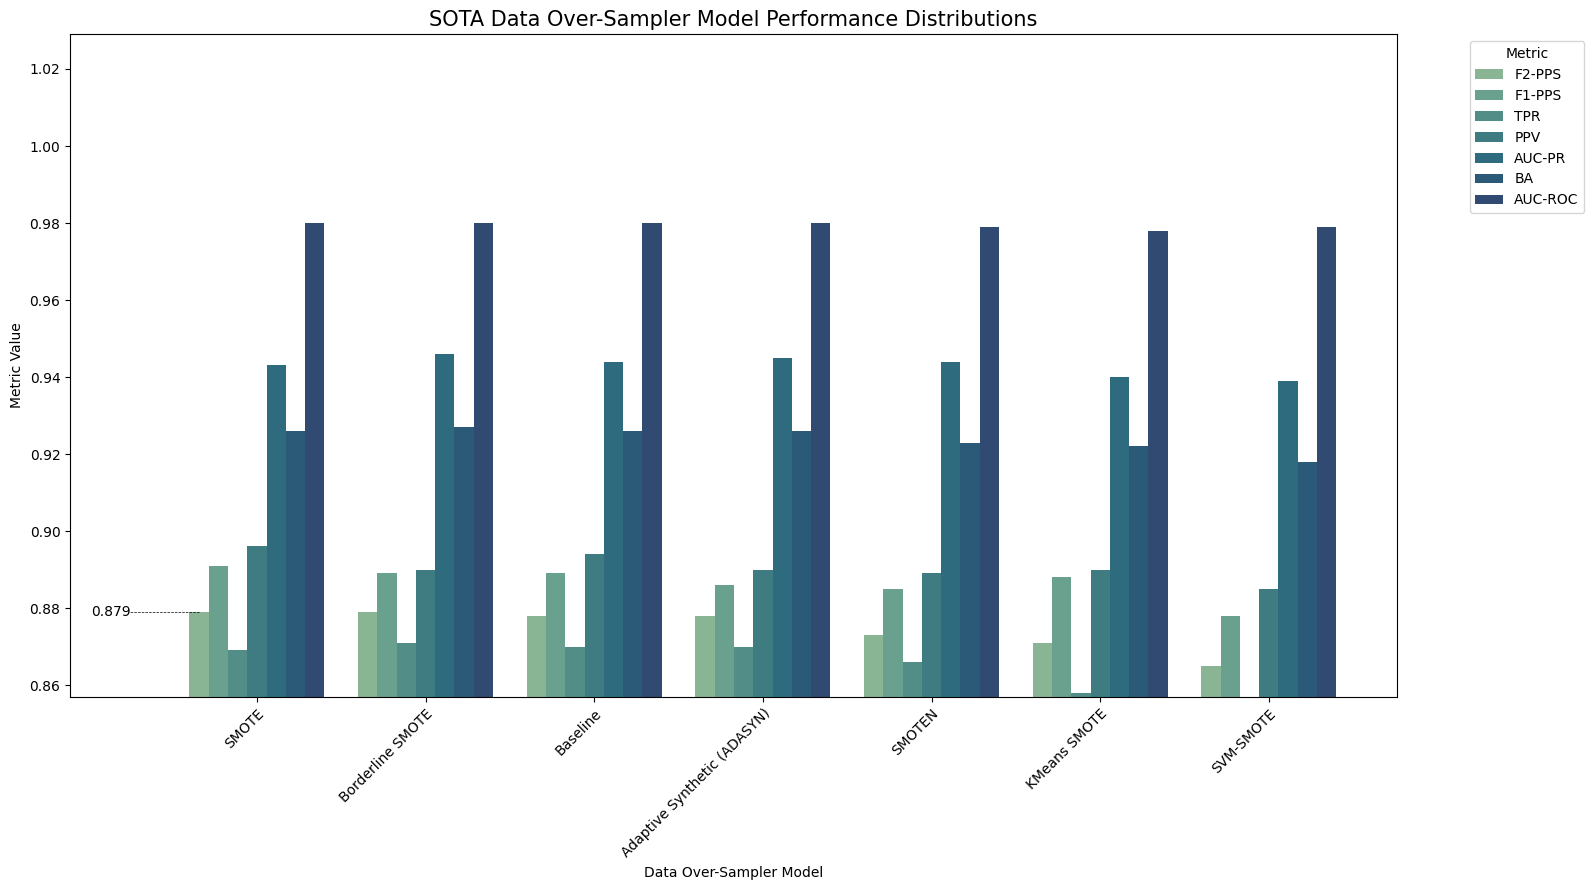

In [49]:
base = select(
    dir = os.path.join(output, f'ranks.csv'),
    title = "SOTA Data Over-Sampler Model",
    column = 'Data Over-Sampler Model',
    output = output,
    main = ['Data Over-Sampler Model'],
    order = order,
    model = None
)